In [1]:
import numpy as np
from scipy.integrate import solve_bvp
from scipy.integrate._bvp import BVPResult
from matplotlib import pyplot as plt

from typing import List, Tuple, Callable

from matplotlib import animation
import matplotlib as mpl

from collections import defaultdict

import subprocess
import shlex
from scipy.special import ellipe

In [2]:

# # ----- WARNING SUPPRESSION -----
# # This should not be used lightly. This is primarily for formatting reasons for our paper.
# import warnings
# warnings.filterwarnings('ignore')

# DEFAULT_FIGSIZE = (5, 5)
# plt.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
# plt.rcParams.update({'font.size': 6})

# mpl.rcParams["figure.dpi"] = 300

# # ---- ENABLE LATEX MATPLOTLIB FONT -----
# # Don't run this cell if you have issues with your latex installation
# # Use LaTeX fonts
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Computer Modern Roman"
# })

# plt.style.use("seaborn-v0_8-muted")

In [3]:
class Planet:
    """Model a planet."""
    
    YEAR_TO_SEC = 31536000
    
    def __init__(
        self,name: str,
        mass: float,
        R1: float,
        R2: float,
        velocity: float,
        radius: float = 0,
        t0=0
    ):
        """Construct a planet, setting its properties and calculating angular velocity of ships on the surface.

        Args:
            name (str): _description_
            mass (float): Mass in units of kg
            R1 (float): Major axis length, units of m
            R2 (float): Minor axis length, units of m
            velocity (float): Speed, units of m/s
            radius (float, optional): _description_. Defaults to 0.
            t0 (int, optional): How far along this is into orbit. units of earth years. Defaults to 0.
        """        
        #Initialize parameters
        self.mass = mass
        self.t0 = t0
        self.R1 = R1
        self.R2 = R2
        self.velocity = velocity
        self.name = name
        self.radius = radius
        #Calculate circumference of ellipse:
        #calculate the circumference of the ellipse using scipy special ellipse integral
        eccentricity_squared = 1-(R2**2)/(R1**2)
        Circumference = 4*R1*ellipe(eccentricity_squared)
        #calculate angular velocity given circumference of orbit, velocity:
        # print(Circumference)
        #(m/s)/m = /s, /s *2*pi = radians/s = ω, angular frequency/velocity
        #So we need 2π*velocity/circumference
        self.omega = 2*np.pi*velocity/Circumference #omega is in units of radians/second

    def position(self,t):
        """
        Even though our units are specified in seconds, we probably want t here to be years
        t = time, units of years, subject to change
        """
        return np.array([self.px(t), self.py(t)])
    
    def px(self,t):
        """
        Even though our units are specified in seconds, we probably want t here to be years
        t = time, units of years, subject to change
        """
        t_new = t + self.t0#add in current + initial time
        t_new = self.YEAR_TO_SEC*t_new#convert from years to seconds
        return self.R1*np.cos(self.omega*t_new)
    
    def py(self,t):
        """
        Even though our units are specified in seconds, we probably want t here to be years
        t = time, units of years, subject to change

        Returns position in km
        """
        t_new = t + self.t0#add in current + initial time
        t_new = self.YEAR_TO_SEC*t_new#convert from years to seconds
        return self.R2*np.sin(self.omega*t_new)
    
    def velocity_vector(self,t):
        """
        t = units of time
        Returns velocity in km/s

        """
        t_new = t + self.t0#add in current + initial time
        t_new = self.YEAR_TO_SEC*t_new#convert from years to seconds
        # (31536000+21600)*t_new
        #calculate unit vector in dir of velocity
        # unit_vector = np.array([-self.R1*np.sin(self.omega*t_new),self.R2*np.cos(self.omega*t_new)])
        # unit_vector = unit_vector/np.linalg.norm(unit_vector)
        # return unit_vector*self.velocity
        return self.omega*np.array([-self.R1*np.sin(self.omega*t_new),self.R2*np.cos(self.omega*t_new)])
    
    def plot_orbit(self,t0,t1):
        t_span = np.linspace(t0,t1,250)
        positions = self.position(t_span)
        plt.plot(positions[0,:],positions[1,:],label = self.name)
        plt.xlabel("x position (m)")
        plt.ylabel("y position (m)")
        plt.legend()
#test velocity:
# Earth = Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0)
# v1 = Earth.velocity_vector(0)
# print(v1)
# print(np.linalg.norm(v1))
# v2 = Earth.velocity_vector(.123)
# print(np.linalg.norm(v2))
# v1 = Earth.velocity_vector(.25)
# print(np.linalg.norm(v1))
# test = np.array([1,2])
# a,b = test
# print(a,b)

In [9]:
# this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)

def best_path(
    planets: List[Planet],
    T: float,
    figname: str | None = None,
    animname: str | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
    Returns:
        BVPResult: Result of solving the BVP.
    """
    
    G = 6.674e-11
    # G=0.1
    M = 1000000.
    def ode(t, y):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        
        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            dist = norm(sx, sy, planet.px(t), planet.py(t))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t)
            dy = sy - planet.py(t)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

            dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
            dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5

        ddsx = G * ddsx + p3/2
        ddsy = G * ddsx + p4/2
        
        dp1 = -p3*G*dp1
        dp2 = -p4*G*dp2
        
        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    target_end_x = planets[1].px(T)+ planets[1].radius
    target_end_y = planets[1].py(T)
    #Velocity BCs
    velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x,velocity_end_y = planets[1].velocity_vector(T)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb):
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,
            
            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
        ])

    t = np.linspace(0, T, N_COMPUTE_STEPS)
    y_guess = np.ones((8, t.size))*1e10
    # y_guess[0:2,0] = [ship_start_x, ship_start_y]
    # y_guess[0:2,-1] = [ship_end_x, ship_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, verbose=2, max_nodes=max_nodes)

    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []

    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(t)
        pyt = planet.py(t)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(t, ux, label='control in x direction')
    control_y_graph, = ax2.plot(t, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()
    
    

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.97e+02       3.89e-18         10000          2129      
       2          2.98e+01       5.05e-11         12129          5832      
       3          2.74e+01       2.88e-12         17961          16464     
       4          6.59e+01       3.45e-14         34425          47545     
       5          1.98e+02       1.17e-07         81970        (138752)    
Number of nodes is exceeded after iteration 5. 
Maximum relative residual: 1.98e+02 
Maximum boundary residual: 1.17e-07


/tmp/ipykernel_17483/564795398.py:172: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_test_newG_M_4.png


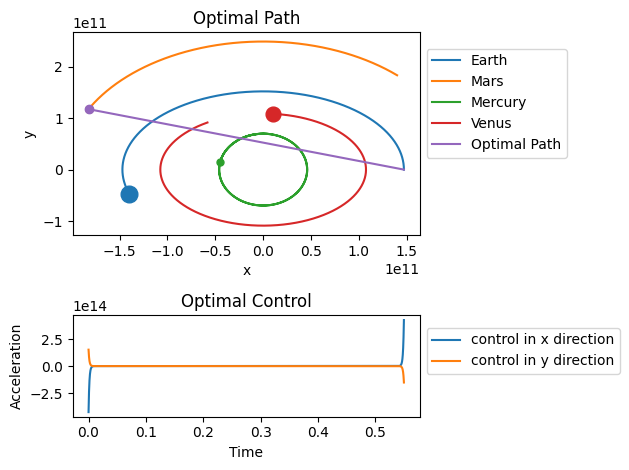

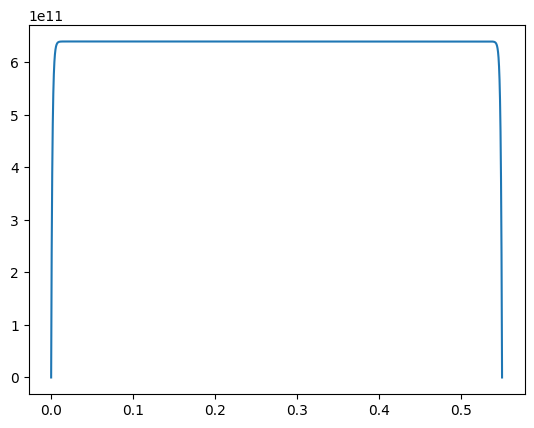

Saving animation...
Animation saved to Earth_Mars_test_newG_M_4.mp4


In [10]:
#Test it with the planets class:
Earth = Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0,radius=6378e3)
Mars = Planet(name='Mars',mass=6.39e23,R1=207e9,R2=249e9,velocity = 24e3,t0=.25,radius=3390e3)
Mercury = Planet(name='Mercury',mass=3.285e23,R1=46e9,R2=69.82e9,velocity = 47.36e3,t0=.55,radius=2440e3)
Venus = Planet(name='Venus',mass=4.8675e24,R1=107.48e9,R2=108.94e9,velocity = 35.02e3,t0=0.21,radius=6051e3)
planets = [Earth,Mars,Mercury,Venus]
best_path(
    planets,
    0.55, 
    figname='Earth_Mars_test_newG_M_4.png',
    animname="Earth_Mars_test_newG_M_4.mp4",
    max_nodes=200000
)

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  


/tmp/ipykernel_17483/564795398.py:66: RuntimeWarning: invalid value encountered in divide
  ddsx += planet.mass*dx/dist3
/tmp/ipykernel_17483/564795398.py:67: RuntimeWarning: invalid value encountered in divide
  ddsy += planet.mass*dy/dist3
/tmp/ipykernel_17483/564795398.py:69: RuntimeWarning: divide by zero encountered in divide
  dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
/tmp/ipykernel_17483/564795398.py:69: RuntimeWarning: invalid value encountered in divide
  dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
/tmp/ipykernel_17483/564795398.py:70: RuntimeWarning: divide by zero encountered in divide
  dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5
/tmp/ipykernel_17483/564795398.py:70: RuntimeWarning: invalid value encountered in divide
  dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5


       1          5.61e+03       1.20e+10         10000          19889     
       2          1.13e+04       7.52e+08         29889         (59283)    
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 1.13e+04 
Maximum boundary residual: 7.52e+08


/tmp/ipykernel_17483/564795398.py:172: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_test2.png


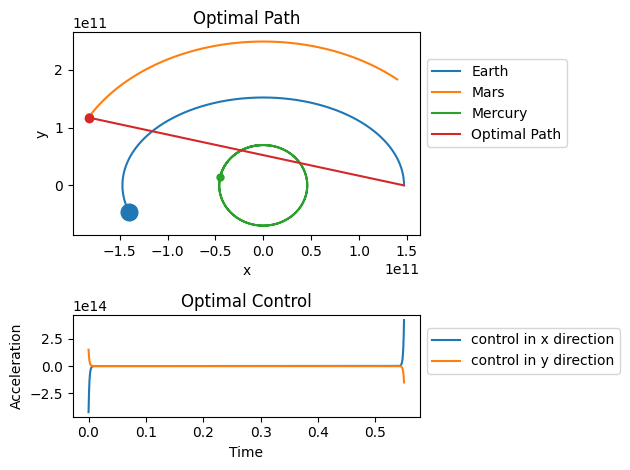

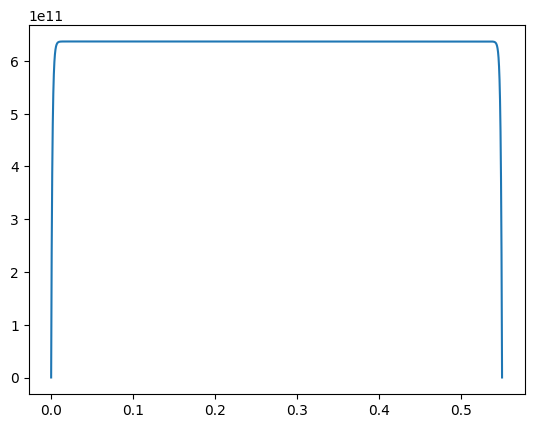

Saving animation...
Animation saved to Earth_Mars_test2.mp4


In [11]:
#Test it with the planets class:
Earth = Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0)
Mars = Planet(name='Mars',mass=6.39e23,R1=207e9,R2=249e9,velocity = 24e3,t0=.25)
Mercury = Planet(name='Mercury',mass=3.285e23,R1=46e9,R2=69.82e9,velocity = 47.36e3,t0=.55)
Sun = Planet(name='Sun',mass=1.989e30,R1=0.1,R2=0.1,velocity = 0.1,t0=0.1)
planets = [Earth,Mars,Mercury]#,Sun]
best_path(
    planets,
    .55,
    figname='Earth_Mars_test2.png',
    animname="Earth_Mars_test2.mp4",
    max_nodes=50000
)

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  


/tmp/ipykernel_17483/564795398.py:66: RuntimeWarning: invalid value encountered in divide
  ddsx += planet.mass*dx/dist3
/tmp/ipykernel_17483/564795398.py:67: RuntimeWarning: invalid value encountered in divide
  ddsy += planet.mass*dy/dist3
/tmp/ipykernel_17483/564795398.py:69: RuntimeWarning: divide by zero encountered in divide
  dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
/tmp/ipykernel_17483/564795398.py:69: RuntimeWarning: invalid value encountered in divide
  dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
/tmp/ipykernel_17483/564795398.py:70: RuntimeWarning: divide by zero encountered in divide
  dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5
/tmp/ipykernel_17483/564795398.py:70: RuntimeWarning: invalid value encountered in divide
  dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5


       1          5.61e+03       1.20e+10         10000          19889     
       2          1.13e+04       7.52e+08         29889         (59283)    
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 1.13e+04 
Maximum boundary residual: 7.52e+08


/tmp/ipykernel_17483/564795398.py:172: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_test_velocity.png


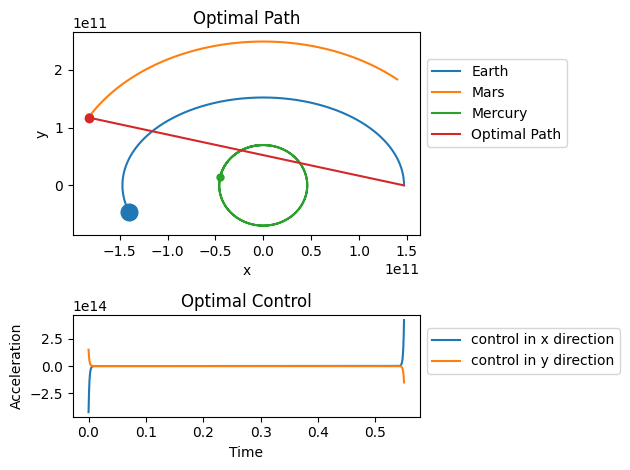

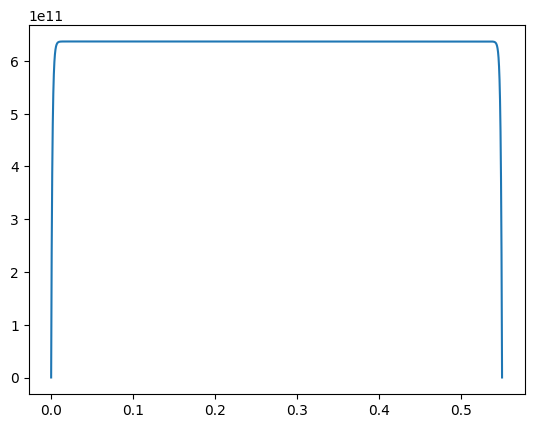

Saving animation...
Animation saved to Earth_Mars_test_velocity.mp4


In [12]:
#Test it with the planets class:
Earth = Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0)
Mars = Planet(name='Mars',mass=6.39e23,R1=207e9,R2=249e9,velocity = 24e3,t0=.25)
Mercury = Planet(name='Mercury',mass=3.285e23,R1=46e9,R2=69.82e9,velocity = 47.36e3,t0=.55)
# Sun = Planet(name='Sun',mass=1.989e30,R1=0.,R2=0.,velocity = 0.,t0=0.)
planets = [Earth,Mars,Mercury]
best_path(
    planets,
    .55, 
    figname='Earth_Mars_test_velocity.png',
    animname="Earth_Mars_test_velocity.mp4",
    max_nodes=50000
)

We saw that with T = 100000 we got a cool graphic

In [ ]:
# best_path(
#     [
#         (5, lambda t:np.ones_like(t)*-1, lambda t:np.ones_like(t)*-1),
#         (10, lambda t: np.ones_like(t)*10, lambda t: np.ones_like(t)*10),
#         (10, lambda t:np.ones_like(t)*0, lambda t:np.ones_like(t)*5)
#     ],
#     10, 
#     figname='fig1.pdf',
#     animname="anim1.mp4",
#     max_nodes=50000
# )

In [ ]:
# best_path(
#     [
#         (10, lambda t:3*np.cos(t)+1, lambda t:np.sin(t)-2),
#         (20, lambda t:2*np.cos(t+np.pi)-3, lambda t:.5*np.sin(t+np.pi)+4),
#         (15, lambda t:np.zeros_like(t)-2, lambda t:np.zeros_like(t)+1),
#     ], 
#     np.pi*2,
#     figname="fig2.pdf",
#     animname="anim2.mp4",
#     max_nodes=300000
# )

In [ ]:
# best_path(
#     [
#         (1, lambda t:3*np.cos(t)+1, lambda t:np.sin(t)-4),
#         (2, lambda t:2*np.cos(t+np.pi)-2, lambda t:.5*np.sin(t+np.pi)+7),
#         (200, lambda t:np.zeros_like(t)-1, lambda t:np.zeros_like(t)+4),
#     ], 
#     np.pi*2,
#     figname="fig3.pdf",
#     animname="anim3.mp4",
# )

In [ ]:
# best_path(
#     [
#         (1, lambda t:10*np.cos(t)+10, lambda t:5*np.sin(t)-4),
#         (10, lambda t:-7*np.cos(3*t+np.pi)-4, lambda t:.5*np.sin(0.1*t+np.pi)+7),
#         (10, lambda t:-7*np.cos(4*t+np.pi)+5, lambda t:4*np.sin(2*t+np.pi)+2),
#         (20, lambda t:4*np.zeros_like(1+t)-1, lambda t:np.zeros_like(t)+4),
#     ], 
#     np.pi*2,
#     figname="fig4.pdf",
#     animname="anim4.mp4",
#     max_nodes=200000
# )

In [ ]:
def combine_test_videos(output_video_name, anim_filenames):
    """Create a unified video that combines the test videos.
    
    This function suppresses errors during running ffmpeg, so
    if it's not working, make sure you have ffmpeg installed on 
    your computer.
    """
    print(f"Combining into {anim_filenames}")
    files = anim_filenames
    
    # Grab singular test video files in this directory.
    # for f in glob.glob("test_*.mp4", root_dir="."):
    #     files.append(f)
    
    # Create a grid by getting the n. rows needed, and duplicating the last video until it's a rectangle
    n_rows = len(anim_filenames) // 3
    n_leftover_spots = len(anim_filenames) % 3
    files += [files[-1] for _ in range(n_leftover_spots)]
    i = 0
    
    # at this point, there are enough videos in files to be rectangular.
    n_rows = len(files) // 3
    
    # Now we construct an ffmpeg command to combine the videos into a 3-column grid.
    inclusion_rows = " ".join([f"-i {files[3*r]} -i {files[3*r+1]} -i {files[3*r+2]}" for r in range(n_rows)])
    filter_complex_rows = "; ".join([f"[{3*r}:v][{3*r+1}:v][{3*r+2}:v]hstack=inputs=3[t{r}]" for r in range(n_rows)])
    vstack_cmd = "".join([f"[t{r}]" for r in range(n_rows)]) + f"vstack=inputs={n_rows}[v]"
    
    # Only combine if all the test files are produced correctly.    
    if len(files) >= 5:
        subprocess.run(shlex.split(f"""ffmpeg -y \
            {inclusion_rows} \
            -filter_complex \
            \"{filter_complex_rows}; {vstack_cmd}\" \
            -map "[v]" \
            {output_video_name}
        """),
            # stdout = subprocess.STDOUT,
            # stderr = subprocess.STDOUT
        )

In [ ]:
# combine_test_videos("combined.mp4", ["anim1.mp4", "anim2.mp4", "anim3.mp4", "anim4.mp4", "anim4.mp4"])

In [ ]:

PlanetType = Tuple[float, Callable[[np.ndarray], np.ndarray], Callable[[np.ndarray], np.ndarray]]

# this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)

def best_path_tf(
    planets: List[Planet],
    T: float,
    figname: str | None = None,
    animname: str | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
    Returns:
        BVPResult: Result of solving the BVP.
    """
    
    # G = 6.674e-11
    G=0.1
    M = 1000000000.
    def ode(t, y, p):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        t *= p[0]
        ddsx = G * sum([planet.mass*(sx-planet.px(t))/(norm(sx, sy, planet.px(t), planet.py(t)))**3 for planet in planets] + p3/(2*M))
        ddsy = G * sum([planet.mass*(sy-planet.py(t))/(norm(sx, sy, planet.px(t), planet.py(t)))**3 for planet in planets] + p4/(2*M))

        dp1 = -p3*(G * sum([planet.mass/norm(sx, sy, planet.px(t), planet.py(t))**3 - 3*planet.mass*(sx - planet.px(t))**2/norm(sx, sy, planet.px(t), planet.py(t))**5 for planet in planets]))
        dp2 = -p4*(G * sum([planet.mass/norm(sx, sy, planet.px(t), planet.py(t))**3 - 3*planet.mass*(sy - planet.py(t))**2/norm(sx, sy, planet.px(t), planet.py(t))**5 for planet in planets]))

        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return p[0]*np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    target_end_x = planets[1].px(1)+ planets[1].radius
    target_end_y = planets[1].py(1)
    #Velocity BCs
    velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x,velocity_end_y = planets[1].velocity_vector(1)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb, p):
        sx, sy = yb[0], yb[1]
        dsx, dsy = yb[2], yb[3]
        p1, p2, p3, p4 = yb[4], yb[5], yb[6], yb[7]
        h = p1*dsx + p2*dsy + p3*(G*sum([planet.mass*(sx-planet.px(p[0]))/(norm(sx, sy, planet.px(p[0]), planet.py(p[0])))**3 for planet in planets] + p3/2)) + p4*(G*sum([planet.mass*(sy-planet.py(p[0]))/(norm(sx, sy, planet.px(p[0]), planet.py(p[0])))**3 for planet in planets] + p4/2)) - (p3/2)**2 - (p4/2)**2

        velocity_end_x,velocity_end_y = planets[1].velocity_vector(p[0])
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,
            
            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - planets[1].px(p[0]) + planets[1].radius,
            yb[1] - planets[1].py(p[0]),
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
            h
        ])

    t = np.linspace(0, 1, N_COMPUTE_STEPS)
    y_guess = np.ones((8, t.size))*1e10
    # y_guess[0:2,0] = [ship_start_x, ship_start_y]
    # y_guess[0:2,-1] = [ship_end_x, ship_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, p=np.array([.75]), verbose=2, max_nodes=max_nodes)

    tf = soln.p[0]
    t *= tf
    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []

    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(t)
        pyt = planet.py(t)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(t, ux, label='control in x direction')
    control_y_graph, = ax2.plot(t, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()
    
    return tf
    

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  


       1          4.71e+12       9.49e+41         50000         (99998)    
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 4.71e+12 
Maximum boundary residual: 9.49e+41


/tmp/ipykernel_14091/2266668074.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_test_newG_M_4_tf.png


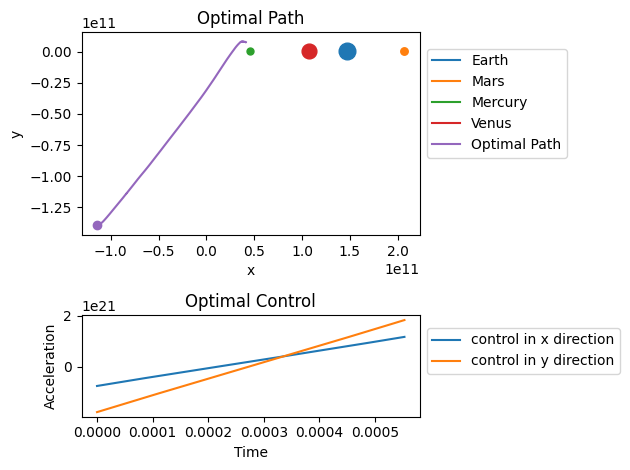

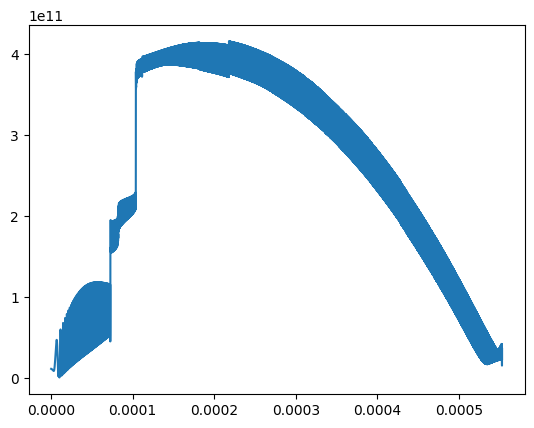

Saving animation...


In [ ]:
#Test it with the planets class:
Earth = Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0,radius=6378e3)
Mars = Planet(name='Mars',mass=6.39e23,R1=207e9,R2=249e9,velocity = 24e3,t0=0,radius=3390e3)
Mercury = Planet(name='Mercury',mass=3.285e23,R1=46e9,R2=69.82e9,velocity = 47.36e3,t0=0,radius=2440e3)
Venus = Planet(name='Venus',mass=4.8675e24,R1=107.48e9,R2=108.94e9,velocity = 35.02e3,t0=0,radius=6051e3)
planets = [Earth,Mars,Mercury,Venus]
best_path_tf(
    planets,
    .55, 
    figname='Earth_Mars_test_newG_M_4_tf.png',
    animname="Earth_Mars_test_newG_M_4_tf.mp4",
    N_COMPUTE_STEPS=50000
)